## Running Model Inference with the ImFusion Python SDK

A MachineLearning model is a class that allows running a complete model on some input data. It consists of the following building blocks:

- Preprocessing: A preprocessing pipeline that matches the (deterministic) pipeline used for training
- Postprocessing: A postprocessing pipeline that performs additional handling of the model output
- Sampling: A strategy for sampling the input and recombining the predictions.
- Engine: An engine that forwards the preprocessed/sampled input to the machine learning framework that runs the saved model 

The configuration of a model is controlled by an inference Yaml configuration file

### Example: Inference Yaml Configuration

```Yaml
Version: 4.0
Type: NeuralNetwork
PredictionType: Classification
PredictionOutput: Image
Name: Bone Segmentation
Description: Segmentation bones in a eyes-to-thighs CT scan

# This selects which framework runs the prediction, can be ['pytorch', 'pyonnxruntime', 'pyopenvino'].
# If `imfusion` includes the TorchPlugin and OnnxPlugin then `torch` and `onnx` are also available.
Engine: pyonnxruntime

# Path to the saved inference model relative to this file. 
ModelFile: model.onnx 

ForceCPU: false	# Option for forcing execution on CPU. Default: false.
Verbose: false	# Option for enabling additional logging during execution. Default: false.

# Defines the processing pipeline before invoking the model.
# Entries are specified as the names of imfusion.machinelearning.Operation subclasses (but without the `Operation` suffix)
PreProcessing:
- MakeFloat:	# Converts the image voxels to float type
- NormalizePercentile:	# Normalizes the voxel values to [0, 1] while taking into account only min to max percentile range
    clamp_values: '0'
    ignore_zeros: '0'
    max_percentile: '0.99'
    min_percentile: '0.01'
    processing_policy: '0'
- Resample:	# Resamples the input to the desired target resolution
    resolution: 4.0 4.0 4.0
- BakeTransformation: {}	# Applies the affine transformation of the input such that the results transformation is the identity

# Defines a sampling strategy to break down large volumes into chunks that the model can handle without going OOM.
Sampling:
- DimensionDivisor: 8	# Pads the image to the next multiple of this number. It is used to make sure that UNet downsampling and upsampling paths produce images of the same size
- MaxSizeSubdivision: 64	# Splits the image in the smallest number of patches of size `MaxSizeSubdivision`. It is used keep VRAM usage under control. Default = -1 to process the entire image at once.
- PixelsOverlap: 16	# Controls the size in pixels of the overlap regions
- RecombineWeighted: true	# Accurate prediction recombination method based on cosine decay. If false, predictions are averaged in the overlapping regions

# Defines processing that is applied to the output of the model
PostProcessing:
- ArgMax: {}	# Converts prediction to a (in this case binary) labelmap
- ResampleToInput: {}	# Resamples the prediction to the geometry of the image given in MachineLearningModel.predict
```

In [1]:
import imfusion
import imfusion.machinelearning as ml
from imfusion_sdk.demo_utils import unzip_folder, mpr_plot

unzip_folder('data/pet-ct-rtstruct.zip')

ct_image, *_ = imfusion.load('data/pet-ct-rtstruct/ct.imf')
bones_segmentation, *_ = imfusion.load('data/pet-ct-rtstruct/bones.imf')


Public beta build of ImFusion Python SDK. Not for commercial use.


In [2]:
# Specify a path the inference yaml config
# (This is a dummy model prepared for the tutorial, briefly trained only on this example)
inference_yaml_config = 'resources/model_onnx.yaml'
# Set up the ML model
model = ml.MachineLearningModel(inference_yaml_config)
# Run the inference
pred_segmentation = model.predict(ct_image)
imfusion.save(pred_segmentation, 'data/pred_segmentation.imf')
pred_segmentation

imfusion.SharedImageSet(size: 1, [imfusion.SharedImage(UBYTE width: 167 height: 167 slices: 247 spacing: 3 mm)])

Target:


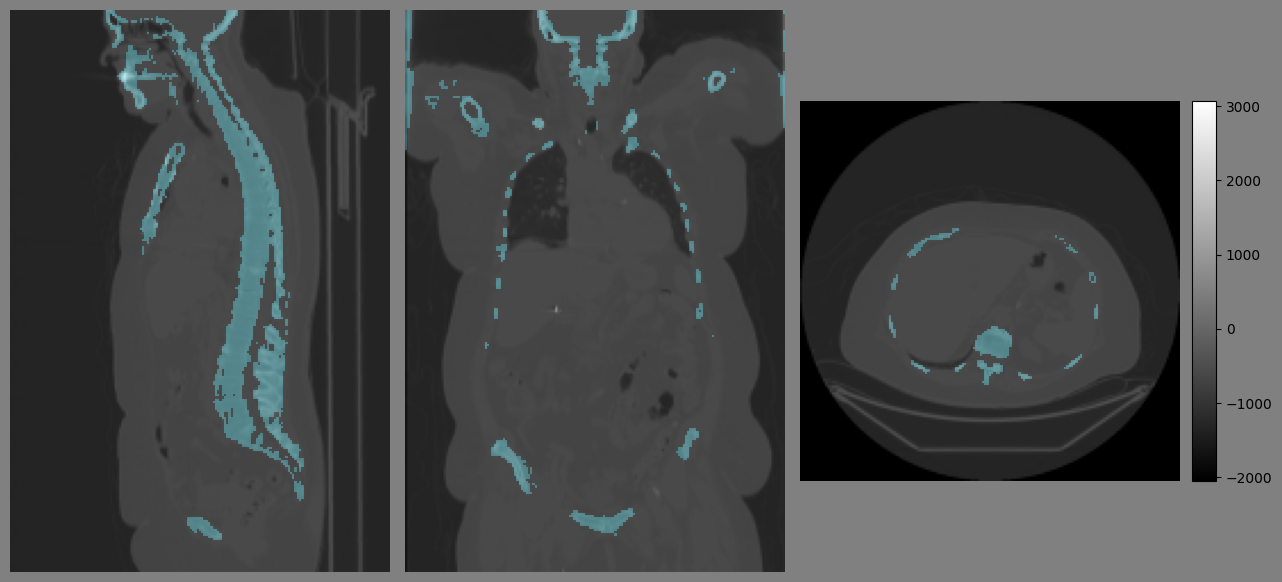

Prediction:


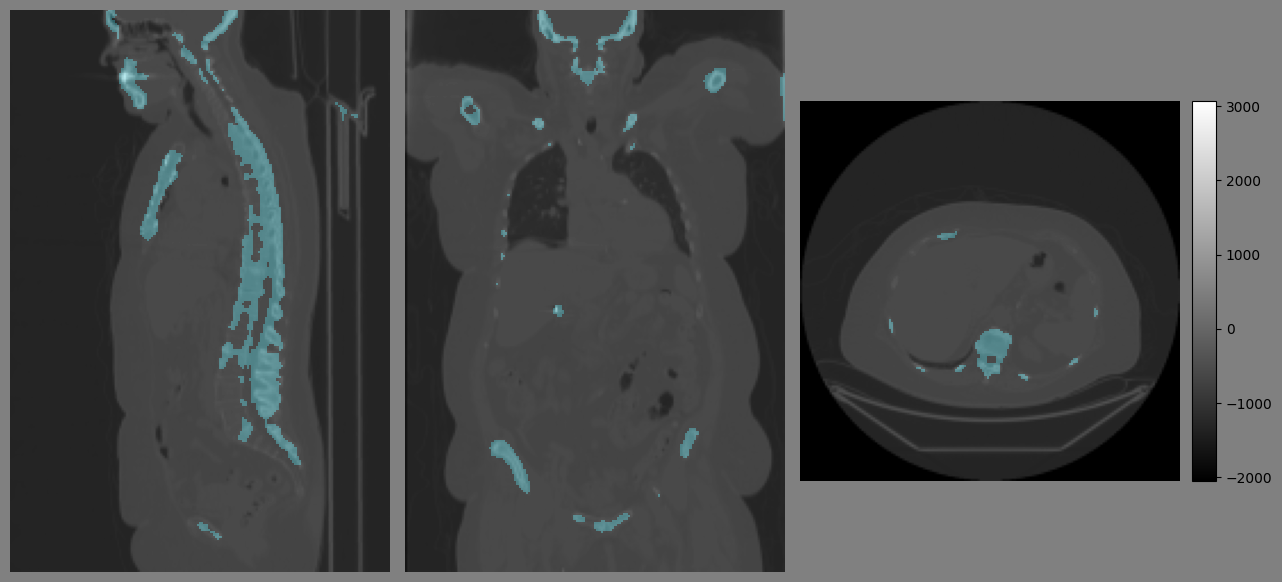

In [3]:
# Visualize the ground truth
print("Target:")
mpr_plot(ct_image[0], labels=bones_segmentation[0])

# Visualize the prediction
print("Prediction:")
mpr_plot(ct_image[0], labels=pred_segmentation[0])

None

In [4]:
# Compute the dice score
dice_score = ml.DiceMetric().compute_dice(pred_segmentation, bones_segmentation)

# dice_score structure: List refers to each image in the image set, in this case only 1
# Dict refers to the label values, 0 = background, 1 = bone.
print(dice_score[0])

{1: 0.645042642699229}
